<font size="8"> **Sea ice seasonality in the Southern Ocean** </font>   
This notebook calculates patterns of sea ice seasonality, that is the start day of sea ice advance, retreat, as well as the total sea ice duration over the sea ice season (February 15 to February 14) in the Southern Ocean following [Masson et al 2013](https://doi.org/10.1371/journal.pone.0064756).  
  
Sea ice seasonality is calculated using daily sea ice concentration data from ACCESS-OM2-01 and the [NASA Goddard-merged Near Real Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration](https://climatedataguide.ucar.edu/climate-data/sea-ice-concentration-data-nasa-goddard-and-nsidc-based-nasa-team-algorithm) (version 3). Both datasets can be found in GADI.  
  
The sea ice seasonality calculations included in this notebook were adapted with permission from the `calc_ice_season` function from the [`aceecostats`](https://github.com/AustralianAntarcticDivision/aceecostats) package for `R` developed by Michael Sumner at AAD.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
#Ensure you update this filepath if you have saved these notebooks elsewhere in your machine
os.chdir(os.path.expanduser('~/ACCESS-OM2-01_EcologicallyRelevantVariables/Scripts'))

You can print your working directory using the chunk below to make sure you are in the correct folder containing these notebooks.

In [ ]:
!pwd

# Loading relevant modules
These modules are used to access relevant outputs and to manipulate data. 

In [2]:
#Loading and manipulating data
import cosima_cookbook as cc
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
import os
from dask.distributed import Client
import geopandas
import string
from itertools import cycle
import xesmf as xe
import scipy.stats as ss

#Analysis module
import ZonalStatsFunctions as zsf

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
#Show plots produced by matplotlib inside this Jupyter notebook
%matplotlib inline

# Setting up notebook

## Parallelising work
Start a cluster that uses multiple cores to parallelise work. Remember that the number of cores cannot exceed the number of CPUs requested when accessing GADI.  
If the line below does not run, skip it. The result is that the job will not be parallelised, but the script will still run.

In [3]:
client = Client(n_workers = 12)

## Starting COSIMA Cookbook session
This way we can search and load ACCESS-OM2-01 outputs with ease.

In [7]:
session = cc.database.create_session()

## Setting up dictionary with frequently used variables in this notebook

A list of experiment outputs available through the Cosima Cookbook can be accessed using `cc.querying.get_experiments(session)`. Use the argument `all = True` to get a detailed list of available experiments.  
Variables included in each experiment can be obtained through `cc.querying.get_variables(session, experiment, frequency)`.

In [4]:
varDict =  {'var_id': 'aice',
            'model': 'ACCESS-OM2-01',
            'expt': '01deg_jra55v140_iaf_cycle2', # ACCESS-OM2-01 cycle 2
            'freq': '1 daily',
            'start_date': range(1965, 2018, 1),
            'offset': np.nan,
            'long_name': 'sea ice seasonality',
            'short_name': 'SIS',
            'unit': 'days',
            'CICE_data': True,
            'Observations': '/g/data/v45/la6889/Observations',
            'climatologies': r'/g/data/v45/la6889/Calculations/SI_seasons/Climatologies',
            'clim_fig': r'/g/data/v45/la6889/Figures/SI_seasons/Climatologies',
            'clipped_data': r'/g/data/v45/la6889/Calculations/SI_seasons/ClippedMEASOregions/',
            'yearly': r'/g/data/v45/la6889/Calculations/SI_seasons/Yearly',
            'decades': range(1965, 2019, 10),
            'res': '0.1°'}

# Accessing sea ice concentration data from observations
Data for the ACCESS-OM2-01 model and satellite observations are available in GADI. The observational data has some missing data between 1979 and 1988. We will interpolate data for the missing periods as described in the next section.

In [11]:
#Observational data file path to main folder location
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'

#Get a list of all files inside the year folders
obsSHFileList = sorted(glob(os.path.join(ObsDir, 'south/daily/*/*'), recursive = True))

#Create a list of the years of interest.
years = np.arange(1978, 2020)

# Load all files that are within the years of interest
for year in years:
    #Create an empty list to hold all filepaths
    fileList = []
    for file in obsSHFileList:
        if file[-18:-14] == str(year):
            #Only one variable 'goddard_merged_seaice_conc' is loaded as it is the only one of interest
            dataarray = xr.open_dataset(file, decode_times = False, autoclose = True)['goddard_merged_seaice_conc']
            fileList.append(dataarray)
    #Create a new data array with all time steps
    fileList = xr.concat(fileList, dim = 'time', coords = 'minimal')    
    if 'time' in fileList.coords:
        #Apply the same time units given in time dimension to time coordinates
        time_units = fileList.time.units
        #Decode date time data to CF conventions
        decoded_time = xr.conventions.times.decode_cf_datetime(fileList.time, time_units)
        fileList.coords['time'] = ('time', decoded_time,
                                   {'long_name': 'time', 'decoded_using': time_units})
    # replace values outside valid range (0-1) with nan
    fileList = fileList.where(xr.ufuncs.logical_and(fileList >=0, fileList <= 1), np.nan)
    
    #Save data array in the observations folder
    fileList.to_netcdf(os.path.join(varDict['Observations'], f'sea_ice_conc_obs_{str(year)}.nc'))

# Dealing with missing dates in sea ice concentration from observations
Data is not available for some periods in the observational data. We applied two different corrections as described in [Masson et al 2013](https://doi.org/10.1371/journal.pone.0064756):  
1. Between January 1979 and November 1987, days of missing data were interpolated from adjoining days  
2. Between December 1987 and January 1988, missing days were replaced with daily climatology (1979-2009)  

## Correcting data between Jan 1979 and Nov 1987
First, we load the data for this period as a data array.

In [16]:
#Observational data file path to main folder location
ObsDir = varDict['Observations']

#For the period between Feb 1979 and Feb 1987, data was interpolated
years = np.arange(1978, 1988)

#Get a list of all files inside the year folders
obs_files = sorted(glob(os.path.join(ObsDir, '*.nc')))

#Empty list to store file list of years when correction will be applied
obslist = []
#Looping through file list
for yr in years:
    [obslist.append(xr.open_dataarray(file)) for file in obs_files if str(yr) in file]

#Creating a multi dimensional array
obs = xr.concat(obslist, dim = 'time').sortby('time')

Now we will identify the missing dates, interpolate data from adjoining days and include these in a corrected dataset.

In [4]:
#Get list of dates not included in observational data
obs_time = obs.time.values
complete_time = pd.date_range(obs.time.values.min(), obs.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))
#Create an empty list to hold interpolated days
int_data = []

#Interpolate only days that are missing
for md in miss_days:
    #Select the day prior and the day after missing date
    int_range = obs.sel(time = slice(md-np.timedelta64(1, 'D'), md+np.timedelta64(1, 'D')))
    #Perform interpolation
    int_range = int_range.interp(time = pd.date_range(md - np.timedelta64(1, 'D'), md + np.timedelta64(1, 'D')))
    #Save interpolated missing date in a list
    int_data.append(int_range.sel(time = md))

#Create a new array with missing dates
obs_corr = xr.concat([obs, xr.concat(int_data, dim = 'time')], dim = 'time').sortby('time')

#Remove variables no longer in use
del obs, years, obslist, obs_time, complete_time, miss_days

We will merge the interpolated data with the original observational data from 1988 to 2009.

In [5]:
#Defining years
years = np.arange(1988, 2010)

#Create empty list to hold file list
obslist = []

#Load data arrays
for yr in years:
    [obslist.append(xr.open_dataarray(file)) for file in obs_files if str(yr) in file]

#Create a new data array to calculate climatology. Joining original files just loaded and the interpolated data
obs_clim = xr.concat([obs_corr.sel(time = slice('1979-01-01', obs_corr.time.values.max())),
                      xr.concat(obslist, dim = 'time')], dim = 'time')

Finally, we will check that there are no other missing days outside the period that we corrected in the previous steps.

In [6]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Checking that there are no missing dates outside 1987-1988
yrs = []
[yrs.append(pd.Timestamp(md).timetuple().tm_year) for md in miss_days]
#Compare years
dif = list(set(yrs) ^ set([1987, 1988]))

#Creating missing list to store data
int_data = []
#Get list of missing data outside 1987-1988
for d in dif:
    for md in miss_days:
        if str(d) in str(pd.to_datetime(md)):
            #Select the day prior and the day after missing date
            int_range = obs_clim.sel(time = slice(md-np.timedelta64(1, 'D'), md+np.timedelta64(1, 'D')))
            #Perform interpolation
            int_range = int_range.interp(time = pd.date_range(md - np.timedelta64(1, 'D'), md + np.timedelta64(1, 'D')))
            #Save interpolated missing date in a list
            int_data.append(int_range.sel(time = md))

#Add interpolated data
obs_clim = xr.concat([obs_clim, xr.concat(int_data, dim = 'time')], dim = 'time').sortby('time')

## Correcting data between Jan 1988 and Nov 1987
Any missing dates between this period will be replaced by the daily climatology calculated from the dataset corrected in the previous step.  
  
First, we calculate the daily climatological mean.

In [24]:
#Calculate climatology
daily_clim = obs_clim.groupby('time.dayofyear').mean('time')

Replacing missing days with daily climatology (1979-2009).

In [12]:
#Get list of dates not included in observational data
obs_time = obs_clim.time.values
complete_time = pd.date_range(obs_clim.time.values.min(), obs_clim.time.values.max()).values

#Find missing days
miss_days = list(set(obs_time) ^ set(complete_time))

#Replace missing dates with climatology
corr_dates = []
for md in miss_days:
    #Add a day to dates in 1987 because daily climatology includes leap day
    if '1987' in str(pd.to_datetime(md)):
        ind = pd.Timestamp(md).timetuple().tm_yday+1
    else:
        ind = pd.Timestamp(md).timetuple().tm_yday
    corr_dates.append(daily_clim.sel(dayofyear = ind).drop('dayofyear').expand_dims({'time': [md]}))

#Save everything in corrected data array
obs_clim = xr.concat([obs_clim, xr.concat(corr_dates, dim = 'time')], dim = 'time').sortby('time')

## Saving corrected observational dataset

In [ ]:
#Defining folder where outputs will be saved
out_file = varDict['Observations']

#Ordering years
years = [*np.arange(1979, 1989), *dif]

#Saving ordered dataset
for yr in years:
    obs_clim.sel(time = str(yr)).to_netcdf(os.path.join(out_file, f'sea_ice_conc_obs_{yr}.nc'))

# Sea ice seasonality calculations
Daily sea ice concentration data from ACCESS-OM2-01 and NASA Goddard were used as inputs for calculation of sea ice advance, retreat and total duration of the sea ice season.

## Define SIS seasons

In [5]:
seasonNames = {'advance': 'Sea ice advance', 
              'retreat': 'Sea ice retreat', 
              'duration': 'Sea ice duration'}

## Loading model data and calculating seasonality

In [6]:
#Defining path where calculations will be saved
dir_out = varDict['yearly']

#Applying calculation for every year
for yr in varDict['start_date']:
    #Loading daily ice data
    SO = zsf.getACCESSdata(varDict['var_id'], str(yr), str(yr+1), 
                           freq = varDict['freq'], ses = session,
                           minlat = -90, maxlat = -45, exp = varDict['expt'], 
                           ice_data = varDict['CICE_data'])
    SO = zsf.corrlong(SO)
    #Calculate sea ice seasons
    adv, ret, sea = zsf.SeaIceAdvArrays(array = SO, dir_out = dir_out)
    del SO, adv, ret, sea

### Loading SIS results from model to avoid recalculating

In [82]:
#Location of SIS files from model output
mod_file = varDict['yearly']

#Load files in a dictionary
mod = {}
mod['advance'] = xr.open_mfdataset(glob(os.path.join(mod_file, '*Adv*.nc'))).aice
mod['retreat'] = xr.open_mfdataset(glob(os.path.join(mod_file, '*Ret*.nc'))).aice
mod['duration'] = xr.open_mfdataset(glob(os.path.join(mod_file, '*Dur*.nc'))).aice

## Based on satellite observations

In [ ]:
#Location of observation-based sea ice concentration
fileList = sorted(glob(os.path.join(varDict['Observations'], '*.nc')))

#Location where output files will be saved
dir_out = os.path.join(varDict['Observations'], 'SIS')

#Load observational data
iceObs = [xr.open_dataarray(f) for f in fileList]
iceObs = xr.concat(iceObs, dim = 'time')

#Calculate sea ice seasons and store in disk
for yr in varDict['start_date']:
    obs = iceObs.sel(time = slice(str(yr), str(yr+1)))
    zsf.SeaIceAdvArrays(obs, dir_out = dir_out)

### Loading SIS results from observations to avoid recalculating

In [6]:
#Location of SIS files from observations
obs_file = os.path.join(varDict['Observations'], 'SIS')

#Load files in a dictionary
obs = {}
obs['advance'] = xr.open_mfdataset(glob(os.path.join(obs_file, '*Adv*.nc'))).goddard_merged_seaice_conc
obs['retreat'] = xr.open_mfdataset(glob(os.path.join(obs_file, '*Ret*.nc'))).goddard_merged_seaice_conc
obs['duration'] = xr.open_mfdataset(glob(os.path.join(obs_file, '*Dur*.nc'))).goddard_merged_seaice_conc

# Loading MEASO regions to overlay them on plots

<AxesSubplot:>

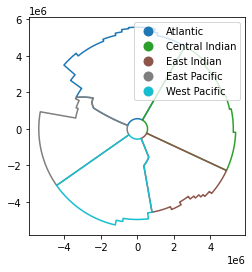

In [7]:
#Load shapefile
MEASO = geopandas.read_file('../SupportingData/MEASO/measo.shp')

#Remove temperate zones as they are not within area of interest
MEASO = MEASO.query('zone != "Temperate"')

#Get sector names from shapefile
sectors = np.unique(MEASO.sector)

#Merge sectors within regions as sea ice is mostly within Antarctic areas
for i, sec in enumerate(sectors):
    pol = MEASO.query(f'sector == "{sec}"').geometry.unary_union
    pol_gs = geopandas.GeoSeries(pol).exterior
    if i == 0:
        MEASO_fixed = pol_gs
    else:
        MEASO_fixed = MEASO_fixed.append(pol_gs)

#Transforming geoseries into geodataframe to add region names
#and adding a new column with the names of the sectors
MEASO_fixed = geopandas.GeoDataFrame(geometry = MEASO_fixed).\
assign(sector = sectors)
        
#Checking results
MEASO_fixed.plot(column = 'sector', legend = True)

# Comparing model and observations estimates in sea ice seasonality
Note that the model data will be regridded to match the observations before comparisons are performed.

## Regridding model outputs (coarsening data)

First, the `x` and `y` axes (containing coordinates) in the data arrays of observations and model data need to be renamed.

In [26]:
#Start empty dictionaries to save renamed model data
model_prep = {}

#Rename coordinates to match observations
for key in mod:
    model_prep[key] = mod[key].sel(time = slice('1979', '2017')).\
    rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})

In [11]:
#Start empty dictionaries to save renamed model data
obs_prep = {}

#Rename coordinates to match observations
for key in obs:
    obs_prep[key] = obs[key].sel(time = slice('1979', '2017')).\
    rename({'longitude': 'lon', 'latitude': 'lat'})

Calculating regridder using the information above. Bilinear interpolation chosen.

In [14]:
#We only need to calculate the regridder once
reg_coarse = xe.Regridder(model_prep[key], obs_prep[key], 'bilinear')

Applying regridder to model and saving regridded data.

In [26]:
#Ensuring folder to save regridded data exists
folder_out = os.path.join(varDict['climatologies'], 'Regridded')
os.makedirs(folder_out, exist_ok = True)

#Empty list to store regridded model data, climatologies and biases
reg_mod = {}

#Apply regridder
for key in model_prep:
    reg_mod[key] = reg_coarse(model_prep[key])
    reg_mod[key]['ygrid'] = obs_prep[key].ygrid
    reg_mod[key]['xgrid'] = obs_prep[key].xgrid
    fn = f'SISeasons_regridded-mod_{key}_1979-2018.nc'
    reg_mod[key].to_netcdf(os.path.join(folder_out, fn))

### Loading regridded model data to avoid recalculating

In [12]:
reg_file = glob(os.path.join(varDict['climatologies'], 'Regridded/*.nc'))

reg_mod = {}
for key in obs_prep:
    reg_mod[key] = xr.open_dataarray([f for f in reg_file if key in f][0])

## Calculating differences and RMSE in climatologies

In [15]:
#Initialising empty dictionary to store results
clim_dif = {}
rmse = {}

#Apply regridder
for key in obs_prep:
    #Calculate differences in SIC
    clim_dif[key] = reg_mod[key].mean('time')-obs_prep[key].mean('time')
    rmse[key] = np.sqrt(((reg_mod[key]-obs_prep[key])**2).mean('time'))

## Plotting results - Figure 4 in publication
Plots include seasonal from model outputs and observations, differences between these (model-obs) and RMSE.

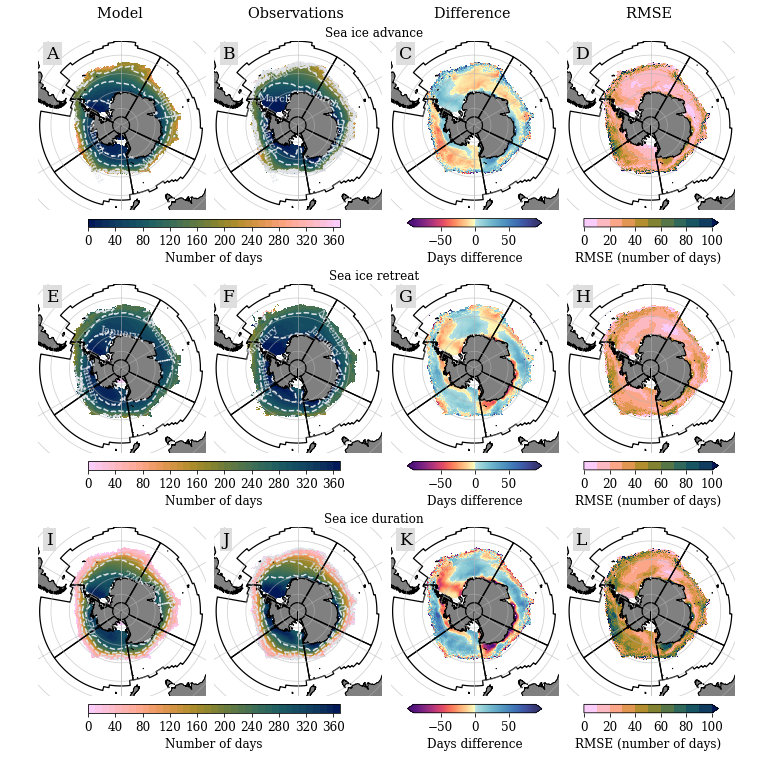

In [59]:
#Ensure folder where figures will be saved exists
folder_out = varDict['clim_fig']
os.makedirs(folder_out, exist_ok = True)

#Initialise figure
fig = plt.figure(figsize = (12.5, 13))

#Colormap settings
#Ensure colormap diverges at zero regardless of max and min values
divnorm = mcolors.TwoSlopeNorm(vmin = -90, vcenter = 0, vmax = 90)
#Create new diverging colormap from existing colormaps to make it
#easy to distinguish positive and negative values
colors1 = plt.cm.magma(np.linspace(0.25, 1, 128))
colors2 = cm.cm.ice_r(np.linspace(0.1, 0.75, 128))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
mymap.set_bad('white')

#Creating color maps to be used in both plot types
roma, roma_r = zsf.colourMaps('../../ScientificColourMaps6/', 'batlow', rev = True)

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

#Defining datasets to be plotted
data = ['Model', 
        'Observations',
        'Difference',
        'RMSE']

counter = zip(cycle(data), np.repeat(list(seasonNames), len(data)))
    
#Create variable containing the Antarctic continent - 50m is medium scale
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', 
                                   edgecolor = 'black', 
                                   facecolor = 'gray', 
                                   linewidth = 0.5)

########
#Create composite figure using a grid
gs = gridspec.GridSpec(nrows = len(seasonNames),
                       ncols = len(data))
#Change the width between each plot
gs.update(wspace = 0.05, hspace = 0.1)

ax = {}

#Create counter using a list: i and j define the plot, while season refers to season
for i, coord in enumerate(counter):  
    ax[i] = fig.add_subplot(gs[i], 
                            projection = ccrs.SouthPolarStereo())
    #Masking 0 values from regridding model data
    model = reg_mod[coord[1]].mean('time').\
    where(reg_mod[coord[1]].lat < -50.2, np.nan)
    obser = obs_prep[coord[1]].mean('time')
    if coord[1] == 'advance':
        cmap = roma
    else:
        cmap = roma_r
    
    #Extract information for each season and start plotting
    if coord[0] == 'Model':
        p1 = model.plot.pcolormesh(ax = ax[i], cmap = cmap, 
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = model.plot.contour(levels = [29, 90, 182], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = model.plot.contour(levels = [274, 335], 
                                          colors = '#dfe3e8', 
                                          ax = ax[i], 
                                          linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = model.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
        axins = inset_axes(ax[i], # here using axis of the first plot
                   width="150%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.3, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)
        cb = fig.colorbar(p1, orientation = 'horizontal', 
                      cax = axins, label = 'Number of days')
        
    #Observational data
    elif coord[0] == 'Observations':
        p2 = obser.plot.pcolormesh(ax = ax[i], cmap = cmap,
                                   levels = np.arange(0, 371, 10),
                                   add_colorbar = False)
        if coord[1] == 'advance':
            labs = obser.plot.contour(levels = [29, 90, 182],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {29: "March", 90: "May", 
                                    182: "August"},
                         fontsize = 10)
        elif coord[1] == 'retreat':
            labs = obser.plot.contour(levels = [274, 335],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True, 
                             fmt = {274: "November",
                                    335: "January"},
                         fontsize = 10)
        else:
            labs = obser.plot.contour(levels = [90, 180, 270],
                                      colors = '#dfe3e8', 
                                      ax = ax[i], 
                                      linestyles = 'dashed')
            ax[i].clabel(labs, labs.levels, inline = True,
                         fontsize = 10)
            
    elif coord[0] == 'Difference':
        #Remove zeroes
        da_d = clim_dif[coord[1]].where(clim_dif[coord[1]] != 0)
        #Plot data
        p3 = da_d.plot(ax = ax[i], cmap = mymap, norm = divnorm,
                       add_colorbar = False)
        axins2 = inset_axes(ax[i], # here using axis of the first plot
                   width="80%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.1, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)

        cb2 = fig.colorbar(p3, cax = axins2, extend = 'both',
                      orientation = 'horizontal',
                      label = 'Days difference')
    else:
        #Plot data
        p4 = rmse[coord[1]].plot(ax = ax[i], cmap = roma_r, 
                                 levels = np.arange(0, 101, 10),
                       add_colorbar = False)
        axins3 = inset_axes(ax[i], # here using axis of the first plot
                   width="80%",  
                   height="5%",  
                   loc='lower left',
                   bbox_to_anchor=(0.1, -0.1, 1, 1),
                   bbox_transform=ax[i].transAxes,
                   borderpad=0)

        cb3 = fig.colorbar(p4, cax = axins3, 
                      orientation = 'horizontal',
                      label = 'RMSE (number of days)')
   
    # Plot MEASO regions
    MEASO_fixed.plot(color = 'black', lw = 1.25, ax = ax[i])
    
    #Set title for each map
    if i < 4:
        ax[i].set_title(f'{coord[0]} \n', y = 1.01)
    else:
        ax[i].set_title(f'', y = 1.01)
    if i in [2, 6, 10]:
        ax[i].text(-0.10, 1.05, f'{seasonNames[coord[1]]}', horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes)
        
    #Remove x and y axes labels
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
      
    #Add land and coastlines
    ax[i].add_feature(land_50m)
    ax[i].coastlines(resolution = '50m')
    
    #Set map extent
    ax[i].set_extent([-180, 180, -90, -42.5], crs = ccrs.PlateCarree())

    #Draw gridlines
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                              color = "#b4b4b4", alpha = 0.6)
    #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    #Set latitude labels to be transparent
    gl.ylabel_style = {'alpha': 0}
    #Remove the outside frame and ticklines of the figure
    [s.set_visible(False) for s in ax[i].spines.values()]
    [t.set_visible(False) for t in ax[i].get_xticklines()]
    [t.set_visible(False) for t in ax[i].get_yticklines()]

#Getting the alphabet in upper case to label plots
labels = string.ascii_uppercase[0:12]

#Apply labels only to plots, not colorbars
for i, a in enumerate(ax):
    ax[a].text(0.05, .9, labels[i], transform = ax[a].transAxes, 
               fontsize = 'x-large',
               bbox = dict(facecolor = '#dedede', edgecolor = 'none',
                               pad = 3.0))

fn = 'MapSeaIceSeasonal_Climatology_RMSE_1979-2018.png'

plt.savefig(os.path.join(folder_out, fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)

# Calculating yearly mean values for SIS per sector

In [80]:
#Loading ice area data (in m2) - Only one file needed as they will be the same regardless of the time
IceArea = xr.open_dataarray('/g/data/v45/la6889/Calculations/Area_per_pixel_01deg/area_per_pixel_01deg_all_areas.nc')

## Correcting longitude in model data 
Longitudes should range from -180 to +180 degrees.

In [83]:
#Select the correct time frame: 1979-2017
for key in mod:
    mod[key] = zsf.corrlong(mod[key].sel(time = slice('1979', '2017')))

## Splitting data into MEASO regions

We will define the MEASO sectors in a specific order so they can be plotted in the way the appear across space.

In [84]:
#Defining sector names in order
sectorNames = ['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific']

In [85]:
#Loading mask
regions = xr.load_dataarray('../SupportingData/Masks/MEASO_SIS_3Dmask.nc')

#Subsetting shapefiles into regions - Initialise dictionary that will contain sector limits
MEASOregions = {}

#Saving each sector as an entry in the dictionary
for i in sectorNames:
    MEASOregions[i] = regions.sel(region = i)
    
MEASOregions.keys()

dict_keys(['Atlantic', 'Central Indian', 'East Indian', 'West Pacific', 'East Pacific'])

## Applying MEASO regions mask to model data

In [74]:
#Ensuring output folder exists
out_file = varDict['clipped_data']
os.makedirs(out_file, exist_ok = True)

#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
clipped_SIS = {}

#Saving each sector as an entry in the dictionary
for season in mod:
    for sector in sectorNames:
        clipped_SIS[f"{sector}_{season}"] = mod[season]*MEASOregions[sector]
        clipped_SIS[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].rename(season)
        clipped_SIS[f"{sector}_{season}"].to_netcdf(os.path.join(out_file, ('SeaIce-' + sector + '_' + season + '-1979-2018.nc')))

In [76]:
#Removing variables no longer needed
del regions

### Loading clipped model data from disk to avoid calculating again

In [77]:
#Clipped data location
out_file = sorted(glob(os.path.join(varDict['clipped_data'], '*.nc')))

#Creating an empty dictionary to load data
clipped_SIS = {}

#Opening all files in a dictionary
for sec in sectorNames:
    #Select all files for each sector
    files = [file for file in out_file if sec in file]
    #Loop through each season within each sector
    for sea in mod:
        filename = [file for file in files if sea in file]
        #Open each file and assign it to dictionary
        clipped_SIS[f'{sec}_{sea}'] = xr.open_dataarray(filename[0], autoclose = True).\
        sel(yt_ocean = slice(-90, -50))
        if sec != 'West Pacific':
            clipped_SIS[f'{sec}_{sea}'] = clipped_SIS[f'{sec}_{sea}'].\
            dropna('xt_ocean', how = 'all')

In [86]:
#Subsetting shapefiles into sectors - Initialise dictionary that will contain sector limits
SIS_weighted = {}

#Saving each sector as an entry in the dictionary
for sector in sectorNames:
    area_reg = IceArea*MEASOregions[sector]
    #Prepare volume data to be used as weights
    area_reg.name = 'weights'
    #Replace NA values with zeroes
    area_reg = area_reg.fillna(0)
    for season in mod:
        SIS_weighted[f"{sector}_{season}"] = clipped_SIS[f"{sector}_{season}"].\
        weighted(area_reg)
        #Saving weighted means per sector (lon, lat)
        SIS_weighted[f"{sector}_{season}"] = SIS_weighted[f"{sector}_{season}"].\
        mean(('xt_ocean', 'yt_ocean'))

## Plotting yearly means with rolling decadal means - Figure A.6
Colourblind palettes were chosen from [https://personal.sron.nl/~pault/#sec:qualitative].

In [87]:
#Create a dictionary to set colors that will be used to represent each sector in all figures
col = ["#4477aa", "#66ccee", "#228833", "#ccbb44", "#ee6677"]
colors = dict(zip(sectorNames, col))

advance Atlantic 0.07647255006144182 -1.894789408428873
advance Central Indian 0.00021057172307606647 -2.6659727984707704
advance East Indian 0.1450882108116723 -1.8535613099988892
advance West Pacific 0.7933416557560256 -0.37451994775534597
advance East Pacific 0.0626623574820245 4.292425992445872
retreat Atlantic 0.32738370742633893 -0.850377330054425
retreat Central Indian 0.9399757039710419 -0.04285629762450422
retreat East Indian 0.543347912571875 -0.7970028274263541
retreat West Pacific 0.8345116607277574 -0.3019693198657212
retreat East Pacific 0.9434303826363027 0.1505370929824756
duration Atlantic 0.5000997513752623 0.9626746680705625
duration Central Indian 0.004705764680624084 2.59528726021649
duration East Indian 0.5421048381342527 1.0751392454218898
duration West Pacific 0.9747170293312314 0.06511682267882311
duration East Pacific 0.036867261989350905 -4.332407890090021


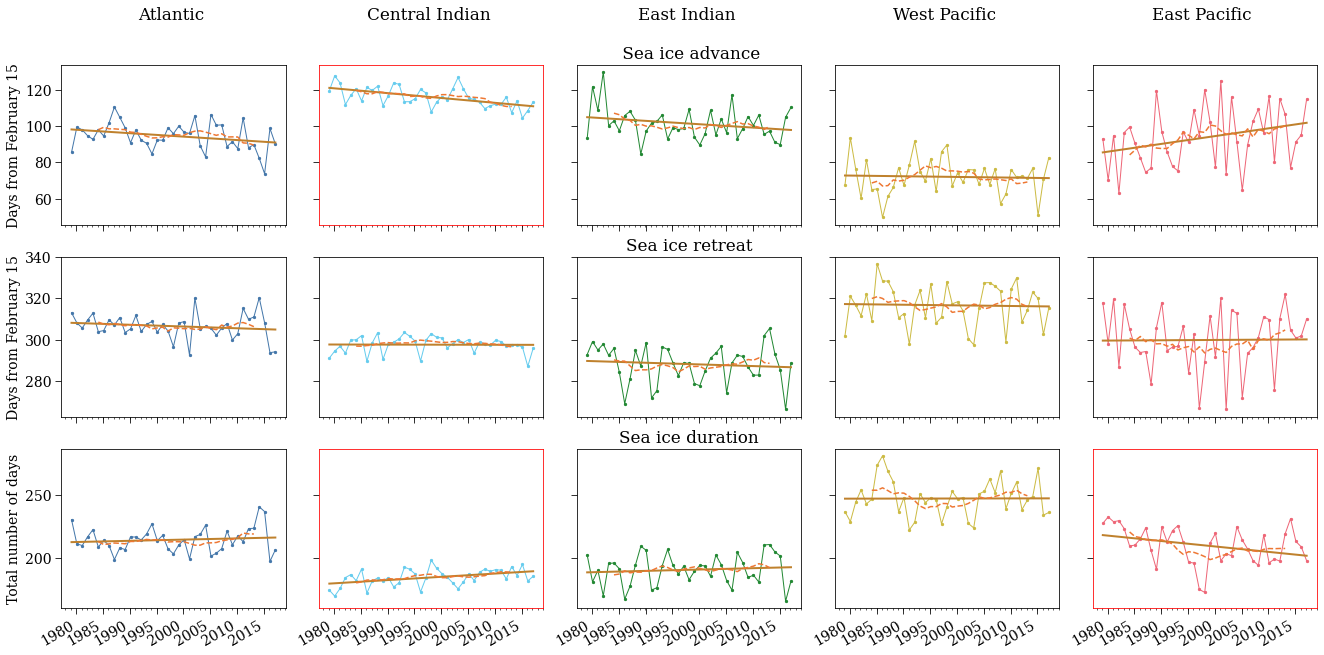

In [95]:
#Maximum and minimum values for the years when plotting    
maxV = SIS_weighted['Atlantic_advance'].indexes['time'].year.max()
minV = SIS_weighted['Atlantic_advance'].indexes['time'].year.min()

#Initialise figure
fig = plt.figure(figsize = (22.5, 10))

#Set font family and font size for the entire graph
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

#Create a grid inside the figure with seasons defining the number of rows and one column
gs = gridspec.GridSpec(nrows = 3, ncols = 1)

#Creating subgrid per row (sea ice seasons)
for i, season in enumerate(seasonNames):
    #Create a list to hold axes information for every row. Each row will contain the same amount of plots as there are sectors.
    axes = np.empty(shape = (1, len(sectorNames)), dtype = object)
    #Create a subgrid for each row in the main grid. Each row will contain the same amount of plots as there are sectors. Decrease blank space between plots
    si_season = gridspec.GridSpecFromSubplotSpec(1, len(sectorNames),
                                                 subplot_spec = gs[i], wspace = 0.15)
    
    #Plotting figures in each grid cell (row wise)
    for j, sec in enumerate(sectorNames):
        #Initilise figures in each grid cell. Ensure x and y axes are shared across the entire row
        ax = plt.Subplot(fig, si_season[0, j], sharex = axes[0, 0], sharey = axes[0, 0])
        fig.add_subplot(ax)
        #Adding local axis value to empty axes list 
        axes[0, j] = ax
        data = SIS_weighted[f'{sec}_{season}']
        #Calculating yearly means per sector and per season, and plotting them
        data.plot(ax = ax, linewidth = 1, marker = 'o', markersize = 2.25, 
                  color = colors[sec])
        slope, inter, rval, pval, se = ss.linregress(data.time.dt.year.values, 
                                                     data.values)
        plt.plot(data.time.values, inter+(slope*data.time.dt.year.values), 
                 label = f'Trend line {sec} (p = {round(pval, 3)})', 
                 color = '#bf812d', linewidth = 2)
        #Calculate the rolling decadal mean per sector and season
        SIS_weighted[f'{sec}_{season}'].rolling(time = 10, center = True).\
        mean().dropna('time').plot(ax = ax, color = '#ee7733', linestyle = '--')
        #Remove x axis label
        ax.set_xlabel('')
        #Increasing the size of the x and y axes ticks
        ax.tick_params(length = 6)
        # For the minor ticks, use no labels; five minor ticks to be included between each major tick pair (i.e., every two years)
        ax.xaxis.set_minor_locator(AutoMinorLocator(n = 5))
        #Specifying how figure titles should appear in each grid cell
        if season == 'advance' and sec == sectorNames[2]:
            ax.set_title(f'{sec} \n \n Sea ice {season}')
        elif season == 'advance' and sec != sectorNames[2]: 
            ax.set_title(f'{sec} \n \n')
        elif season != 'advance' and sec == sectorNames[2]:
            ax.set_title(f'Sea ice {season}')
        else:
            ax.set_title('')
        #Show x tick labels only in the last row
        if season != 'duration':
            ax.set_xticklabels([])
        #Include the y axis title and labels only for the first column
        if sec == sectorNames[0] and season != 'duration':
            ax.set_ylabel('Days from February 15')
        #The last row of the first column has a different axis title
        elif sec == sectorNames[0] and season == 'duration':
            ax.set_ylabel('Total number of days')
        #Remove all y labels and titles in any other grid cell
        else:
            ax.set_ylabel('')
            ax.yaxis.set_tick_params(labelleft = False) 
        print(season, sec, pval, slope*10)
        if pval < 0.05:
            for pos in ['top', 'bottom', 'right', 'left']:
                ax.spines[pos].set_edgecolor('red')

fn = f'SeaIceTrends_MEASOsectors_{str(minV)}-{str(maxV)}.png' 

# #Saving final figure
plt.savefig(os.path.join(varDict['lm_fig'], fn), dpi = 300, bbox_inches = 'tight', 
            pad_inches = 0.05)